In [4]:
# from theano.sandbox import cuda
# cuda.use('gpu0')
import tensorflow
import os, sys
current_dir = os.getcwd()
from keras.layers import Merge
import time
# import imageio
from keras.models import model_from_json
import bcolz
import pdb
import tensorflow as tf
import pandas as pd
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [210]:
import utils; reload(utils)
import model_util; reload(model_util)
from model_util import *
from utils import *
from IPython.display import FileLink
%matplotlib inline
from random import shuffle
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rc('font', family='serif')

In [7]:
seed = 7
np.random.seed(seed)

In [211]:
vi = visualization()

In [8]:
dh = data_handler()
laser, rgb, depth, ret = dh.load(data_path = 'data/sensor/')

laser_shuffle = []
rgb_shuffle = []
depth_shuffle = []
index_shuf = range(laser.shape[0])
shuffle(index_shuf)
for i in index_shuf:
    laser_shuffle.append(laser[i])
    rgb_shuffle.append(rgb[i])
    depth_shuffle.append(depth[i])

In [9]:
laser = np.array(laser_shuffle)
rgb = np.array(rgb_shuffle)
depth = np.array(depth_shuffle)

# km = keras_model(output_shape = laser.shape[1])

print 'Laser: ' + str(laser.shape)
print 'Depth: ' + str(depth.shape)
print 'RGB: ' + str(rgb.shape)
N = laser.shape[0]
rgb_train = rgb

batch_size = 64
no_of_epochs = 1
# km.compile()


Laser: (4756, 121)
Depth: (4756, 40, 640, 1)
RGB: (4756, 40, 640, 3)


In [206]:
# km.final_model.fit([depth, rgb], laser, validation_split = 0.2,nb_epoch=no_of_epochs, batch_size=batch_size,callbacks=[km.tbCallback, km.lrate])

In [207]:
def mean_squared_error_exp(y_true, y_pred):
#     diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),K.epsilon(),None))
    return K.mean(K.square(y_pred - y_true), axis=-1) + K.mean(K.square(tf.maximum(0.,y_pred-y_true)),axis=-1) + K.mean(K.square(tf.maximum(0.,-(y_pred+0.5))),axis=-1)
#+ K.mean(tf.log(1.+tf.exp(y_pred-(y_true+0.3))) ,axis=-1)
#+10.*K.mean(tf.log(1.+tf.exp(10.*(-y_pred+0.3))),axis=-1)+K.mean(tf.log(1+tf.exp(y_pred-(y_true+0.3))) ,axis=-1)
#+100. * K.mean(diff, axis=-1)
# (1e-6/(1+tf.exp(y_pred*100-0.3)

In [208]:
def conv1():
    rgb_model = Sequential([
            BatchNormalization(axis=1, input_shape=(40,640,3)),
            Convolution2D(8,3,3, activation='relu',dim_ordering = 'tf'),
            MaxPooling2D((2,2)),
            BatchNormalization(axis=1),
            Convolution2D(8,3,3, activation='relu',dim_ordering = 'tf'),
            MaxPooling2D((2,2)),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu',dim_ordering = 'tf'),
#             Convolution2D(32,1,3, activation='relu',dim_ordering = 'tf'),
            MaxPooling2D((4,4)),
            BatchNormalization(axis=1),
#             MaxPooling2D((1,3)),
#             Convolution2D(64,1,11, activation='relu',dim_ordering = 'tf'),
#             MaxPooling2D((2,3)),
            Flatten()
#             Dense(200, activation='relu'),
#             BatchNormalization(),
#             Dense(233, activation='linear')
        ])
    depth_model = Sequential([
            BatchNormalization(axis=1, input_shape=(40,640,1)),
            Convolution2D(8,3,3, activation='linear',border_mode='same',dim_ordering = 'tf'),
            AveragePooling2D((3,3)),
            BatchNormalization(axis=1),
            Convolution2D(8,3,3, activation='relu',border_mode='same',dim_ordering = 'tf'),
            Convolution2D(16,3,3, activation='relu',border_mode='same',dim_ordering = 'tf'),
            AveragePooling2D((2,2)),
            BatchNormalization(axis=1),
            Convolution2D(16,3,3, activation='relu',dim_ordering = 'tf'),
            AveragePooling2D((3,3)),
            BatchNormalization(axis=1),
            Convolution2D(128,1,3, activation='relu',border_mode='same',dim_ordering = 'tf'),
            AveragePooling2D((1,3)),
            BatchNormalization(axis=1),
            Flatten()
#             Dense(640, activation='relu')
#             Dense(512, activation='relu')
#             Dense(640, activation='relu')
#             BatchNormalization()
#             Dense(233, activation='linear')
        ]) 
    final_model = Sequential()
    final_model.add(Merge([rgb_model, depth_model],mode='concat'))
    final_model.add(Dropout(0.5))
    final_model.add(BatchNormalization())
    final_model.add(Dense(512, activation='relu',init='lecun_uniform'))
    final_model.add(Dropout(0.5))
    final_model.add(BatchNormalization())
    final_model.add(Dense(121, activation='linear', init='lecun_uniform'))
    

#     model.fit_generator([rgb, laser],laser.shape[0], nb_epoch=no_of_epochs)
#     model.optimizer.lr = 0.001
#     model.fit_generator(depth, laser, validation_split = 0.2,nb_epoch=no_of_epochs, batch_size=batch_size)
    return final_model

model = conv1()

In [209]:
def mean_squared_error_exp(y_true, y_pred):
#     diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),K.epsilon(),None))
    return K.mean(K.square(y_pred - y_true), axis=-1) + K.mean(K.square(tf.maximum(0.,y_pred-y_true)),axis=-1) + K.mean(K.square(tf.maximum(0.,-(y_pred+0.5))),axis=-1)
#+ K.mean(tf.log(1.+tf.exp(y_pred-(y_true+0.3))) ,axis=-1)
#+10.*K.mean(tf.log(1.+tf.exp(10.*(-y_pred+0.3))),axis=-1)+K.mean(tf.log(1+tf.exp(y_pred-(y_true+0.3))) ,axis=-1)
#+100. * K.mean(diff, axis=-1)
# (1e-6/(1+tf.exp(y_pred*100-0.3)

In [210]:
sgd = SGD(lr=0.0, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd, loss='mse')
# mean_squared_error_exp

In [211]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_144 (BatchNor (None, 40, 640, 3)    160                                          
____________________________________________________________________________________________________
convolution2d_108 (Convolution2D (None, 38, 638, 8)    224                                          
____________________________________________________________________________________________________
maxpooling2d_43 (MaxPooling2D)   (None, 19, 319, 8)    0                                            
____________________________________________________________________________________________________
batchnormalization_145 (BatchNor (None, 19, 319, 8)    76                                           
___________________________________________________________________________________________

In [212]:
#model.load_weights('models/model_notebook.h5')

In [213]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [214]:


# model.optimizer.lr=0.1
# tbCallback=keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

In [215]:
N_s = 0
N = N_s + 400
laser_s = laser[N_s:N,:]
rgb_s = rgb[N_s:N,:,:,:]
depth_s = depth[N_s:N,:,:]
batch_size = 64
no_of_epochs = 50
# validation_split = 0.2
model.fit([rgb_s,depth_s], laser_s, nb_epoch=no_of_epochs, validation_split = 0.2, batch_size=batch_size,callbacks=[lrate])

Train on 320 samples, validate on 80 samples
Epoch 1/50
320/320 [==============================] - 5s - loss: 9.2916 - val_loss: 1411.8538
Epoch 2/50
320/320 [==============================] - 5s - loss: 6.0212 - val_loss: 41757.4441
Epoch 3/50
320/320 [==============================] - 5s - loss: 2.7151 - val_loss: 24141.2195
Epoch 4/50
320/320 [==============================] - 5s - loss: 1.6292 - val_loss: 7640.4596
Epoch 5/50
320/320 [==============================] - 5s - loss: 1.4988 - val_loss: 6969.0586
Epoch 6/50
320/320 [==============================] - 5s - loss: 1.2747 - val_loss: 19278.4879
Epoch 7/50
320/320 [==============================] - 5s - loss: 1.0940 - val_loss: 10325.2682
Epoch 8/50
320/320 [==============================] - 5s - loss: 1.0560 - val_loss: 8383.0188
Epoch 9/50
320/320 [==============================] - 5s - loss: 1.0290 - val_loss: 3826.2230
Epoch 10/50
320/320 [==============================] - 5s - loss: 0.9407 - val_loss: 1868.3803
Epoch 11/5

In [216]:
# N = 300
# result = model.predict([depth[N:N+1,:,:,:]])
# result = model.predict([rgb[N:N+1,:,:,:], depth[N:N+1,:,:,:]])
# pose = [0.,0.,0.]
# vi.depth_plot(np.mean(depth[N,15:35,:,:],axis=0),pose)
# vi.laser_plot2(np.mean(depth[N,15:35,:,:],axis=0),640,'g')
# vi.laser_plot2(laser[N,:],100,'b')
# vi.laser_plot2(result[0],100,'r')
# plt.plot(0,0,'or')

In [217]:
model_json = model.to_json()
with open("models/model_low_p.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
json_file.close()
model.save_weights("models/model_notebook_low_p.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
#  for paper use model_low.json with model_notebook_low.h5
json_file = open('models/model_low.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("models/model_notebook_low.h5")
print("Loaded model from disk")

Loaded model from disk


In [323]:
result.shape

(1, 121)

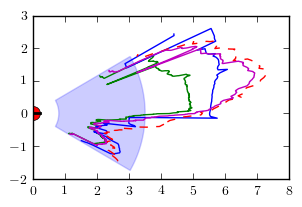

In [411]:
N = 30
result = loaded_model.predict([rgb[N:N+1,:,:,:], depth[N:N+1,:,:,:]])
pose = [0.,0.,0.]

vi.start_fig((3.3,2.1))
# ax = fig.add_subplot(1, 1, 1)
# vi.fov((0.,0.), -30, 30,100,fill=True, color='blue')

vi.laser_plot2(np.mean(depth[N,15:35,:,:],axis=0).T[0],640,'g','RGB-D')
vi.laser_plot2(laser[N,:],laser.shape[1],'b','Ground truth')
vi.laser_plot2(result[0],laser.shape[1],'r--','Prediction')
depth_new = np.mean(depth[N,15:35,:,:],axis=0).T[0]

from scipy.interpolate import interp1d
laser_fov = result[0]
original_span = np.linspace(0,1,laser_fov.shape[0])
f = interp1d(original_span,laser_fov)
reduced_span = np.linspace(0,1,640)
laser_fov = f(reduced_span)

def bayes_update(prior_array, likelihood_array):
    fused_out = []
    for i in range(prior_array.shape[0]):
        prior = prior_array[i]
        likelihood = likelihood_array[i]
        x = np.linspace(0,10,1000)
        mu = prior
        mu2 = likelihood
        sigma = 1./10*(prior)**2
        sigma2 = 1./(1+np.exp(-likelihood-4))
        pz = 1./(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))
        pdz = 1./(2*np.pi*sigma2**2)*np.exp(-(x-mu2)**2/(2*sigma2**2))
        fused_out.append(x[np.argmax(pdz*pz)])
    return fused_out
# post = np.zeros(640)


post = bayes_update(depth_new,laser_fov) 

    
result_new = depth_new*np.exp(-(depth_new)**2/(2*2)**2)+laser_fov*np.exp(-(laser_fov+3)**2/(2*4)**2)
vi.laser_plot2(post,result_new.shape[0],'m','Proposed')
# vi.set_lim([-0.5,10],[-3,3.5],1,False)
# vi.save_fig('007.pdf')

In [381]:
post_np = np.array(post)
post_np.shape

(640,)

In [327]:
def resample_data(data, num):
    original_span = np.linspace(0,1,data.shape[0])
    f = interp1d(original_span,data)
    reduced_span = np.linspace(0,1,num)
    return f(reduced_span)

# new_scan = resample_data(result[0],121)
# new_scan.shape

In [413]:
import random
num_sample = 1000
gt = []
rgbd = []
pred = []
predb = []
result = loaded_model.predict([rgb[N:N+1,:,:,:], depth[N:N+1,:,:,:]])
for N in range(num_sample):
    result = loaded_model.predict([rgb[N:N+1,:,:,:], depth[N:N+1,:,:,:]])
    depth_new = np.mean(depth[N,15:35,:,:],axis=0).T[0]
    laser_fov = result[0]
    original_span = np.linspace(0,1,laser_fov.shape[0])
    f = interp1d(original_span,laser_fov)
    reduced_span = np.linspace(0,1,121)
    laser_fov = f(reduced_span)
    laser_rs = resample_data(laser[N,:],121)
    depth_new =  resample_data(depth_new,121)
    gt.append(laser[N,:])
    rgbd.append(depth_new-laser[N,:])
    pred.append(laser_fov-laser[N,:])
    predb.append(bayes_update(depth_new,laser_fov)-laser[N,:])
    

preda = np.array(pred)
preda = preda.flatten()
predba = np.array(predb)
predba = predba.flatten()

gta = np.array(gt)
gta = gta.flatten()

rgbda = np.array(rgbd)
rgbda = rgbda.flatten()

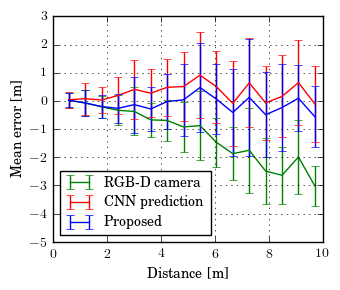

In [414]:
# fig = plt.figure()
# plt.errorbar(gta,gta,yerr=rgbda,ecolor='b')
# plt.errorbar(gta,gta,yerr=preda,ecolor='r')


histogram=plt.figure(figsize=(3.5,3), dpi=80)

# x = [random.gauss(3,1) for _ in range(400)]
# y = [random.gauss(4,2) for _ in range(400)]

nbins = 16

n, _ = np.histogram(gta, bins=nbins)
sy, _ = np.histogram(gta, bins=nbins, weights=rgbda)
sy2, _ = np.histogram(gta, bins=nbins, weights=rgbda*rgbda)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='g-',label='RGB-D camera')
# bins = np.linspace(0, 10, 100)
# plt.errorbar(gta,rgbd_a, alpha=0.5)

n, _ = np.histogram(gta, bins=nbins)
sy, _ = np.histogram(gta, bins=nbins, weights=preda)
sy2, _ = np.histogram(gta, bins=nbins, weights=preda*preda)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-',label='CNN prediction')

n, _ = np.histogram(gta, bins=nbins)
sy, _ = np.histogram(gta, bins=nbins, weights=predba)
sy2, _ = np.histogram(gta, bins=nbins, weights=predba*predba)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='b-',label='Proposed')

# from matplotlib.backends.backend_pdf import PdfPages
# plt.hist(y, bins, alpha=0.5)
plt.ylabel('Mean error [m]')
plt.xlabel('Distance [m]')
plt.legend(loc='lower left',fontsize=10)
plt.axis([0, 10, -5, 3])
plt.grid()
plt.tight_layout()
pp = PdfPages('comparison.pdf')
pp.savefig(histogram)
pp.close()
plt.show()



# plot_url = py.plot_mpl(histogram, filename='docs/histogram-mpl-same')

In [285]:
import utils; reload(utils)
import model_util; reload(model_util)
from model_util import *
from utils import *
from IPython.display import FileLink
%matplotlib inline
from random import shuffle
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rc('font', family='serif')
vi = visualization()